**Modelización**

*   Angel Luis Parra Marcos


<p style="font-size: 36px; font-weight: bold;">Predicción del precio de la propiedad</p>
<p style="font-size: 30px; font-weight: bold;">Property Sales Data (Milwaukee)</p>


In [1]:
import pandas as pd
import numpy as np
import os
import plotnine as pn
from plotnine import *
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance


# Carga del fichero

In [2]:
propiedades = pd.read_csv('propiedades_clean.csv')

propiedades.shape

(59930, 18)

In [3]:
propiedades.isnull().sum()

proptype        0
taxkey          0
address         0
district        0
nbhd            0
style           1
stories         0
year_built      0
rooms           0
finishedsqft    0
units           0
bdrms           0
fbath           0
hbath           0
lotsize         0
sale_date       0
sale_price      0
age_at_sale     0
dtype: int64

In [4]:
propiedades.loc[propiedades['style'].isnull()]

,proptype,taxkey,address,district,nbhd,style,stories,year_built,rooms,finishedsqft,units,bdrms,fbath,hbath,lotsize,sale_date,sale_price,age_at_sale
15562,Condominium,430499000.0,7828 W HEATHER AV,9.0,5069,NaN,2,1978.0,6,1508.0,1.0,2,2,0,0.0,2014-11-01,45000.0,36.0


**SE ELIMINA UN REGISTRO DE LOS 59930 REGISTROS POR SER NULO EN STYLE**

In [5]:
propiedades = propiedades[~propiedades['style'].isnull()]

In [6]:
propiedades.shape

(59929, 18)

In [7]:
propiedades.head(5)

,proptype,taxkey,address,district,nbhd,style,stories,year_built,rooms,finishedsqft,units,bdrms,fbath,hbath,lotsize,sale_date,sale_price,age_at_sale
0,Commercial,3.230461e+09,2628 N 6TH ST,6.0,6258,commercial exempt,2,1880.0,0,1840.0,1.0,0,0,0,12750.0,2002-01-01,45000.0,122.0
1,Commercial,3.590192e+09,1363 N PROSPECT AV,3.0,6262,mansions with commercial usage,2,1876.0,0,4174.0,1.0,0,0,0,11840.0,2002-01-01,465000.0,126.0
2,Commercial,4.161194e+09,617 S 94TH ST,10.0,6272,service building,1,1954.0,0,4174.0,1.0,0,0,0,9700.0,2002-01-01,119000.0,48.0
3,Commercial,1.719836e+09,3624 W SILVER SPRING DR,1.0,6218,store bldg,2,1955.0,0,4174.0,1.0,0,0,0,8792.0,2002-01-01,210000.0,47.0
4,Commercial,3.480290e+09,3830 W LISBON AV,15.0,6254,store bldg,2,1909.0,0,4174.0,1.0,0,0,0,4840.0,2002-01-01,48500.0,93.0


In [8]:
propiedades.dtypes

proptype         object
taxkey          float64
address          object
district        float64
nbhd              int64
style            object
stories           int64
year_built      float64
rooms             int64
finishedsqft    float64
units           float64
bdrms             int64
fbath             int64
hbath             int64
lotsize         float64
sale_date        object
sale_price      float64
age_at_sale     float64
dtype: object

# Gestion de variables

**Se van a eliminara las varibales 'taxkey' y 'address' pues he considerado que estas van a meter ruido a los modelos.
También he considerado que no voy a usar 'sale_date' pues el modelo que podría aprender con esta variable patrones del pasado que no tienen porque repetirse en el futuro**

In [9]:
propiedades = propiedades.drop(columns=['taxkey', 'address','sale_date'])

In [10]:
propiedades.columns

Index(['proptype', 'district', 'nbhd', 'style', 'stories', 'year_built',
       'rooms', 'finishedsqft', 'units', 'bdrms', 'fbath', 'hbath', 'lotsize',
       'sale_price', 'age_at_sale'],
      dtype='object')

In [11]:
propiedades.dtypes

proptype         object
district        float64
nbhd              int64
style            object
stories           int64
year_built      float64
rooms             int64
finishedsqft    float64
units           float64
bdrms             int64
fbath             int64
hbath             int64
lotsize         float64
sale_price      float64
age_at_sale     float64
dtype: object

In [12]:
propiedades['district'] = propiedades['district'].astype('int64')

In [13]:
propiedades.head(5)

,proptype,district,nbhd,style,stories,year_built,rooms,finishedsqft,units,bdrms,fbath,hbath,lotsize,sale_price,age_at_sale
0,Commercial,6,6258,commercial exempt,2,1880.0,0,1840.0,1.0,0,0,0,12750.0,45000.0,122.0
1,Commercial,3,6262,mansions with commercial usage,2,1876.0,0,4174.0,1.0,0,0,0,11840.0,465000.0,126.0
2,Commercial,10,6272,service building,1,1954.0,0,4174.0,1.0,0,0,0,9700.0,119000.0,48.0
3,Commercial,1,6218,store bldg,2,1955.0,0,4174.0,1.0,0,0,0,8792.0,210000.0,47.0
4,Commercial,15,6254,store bldg,2,1909.0,0,4174.0,1.0,0,0,0,4840.0,48500.0,93.0


## Gestión Variable Style

In [14]:
 propiedades['style'].unique()

array(['commercial exempt', 'mansions with commercial usage',
       'service building', 'store bldg', 'strip shopping center',
       'svs station w conv store', 'tavern', 'ap 1', 'day care center',
       'duplex old/style', 'office building', 'pole building',
       'residence with commercial usage', 'used car sale',
       'warehouse building', 'apartment', 'beer depot & liquor store',
       'store building', 'fast food operation', 'multi story warehouse',
       'sit down restaurant', 'triplex', 'rm or rooming house',
       'laundry pick-up station', 'auto & auto body repair',
       'custard stand, drive-in', 'muffler shop', 'salvage yard',
       'super market', 'svc station w conv and carwash',
       'bank, savings & loan', 'medical clinic', 'pharmacy',
       'tire dealer', 'mansion', 'duplex o/s', 'church', 'cottage',
       'laundromat', 'rooming house', 'trucking terminal',
       'auto rental agency', 'car dealer, truck dealer', 'cape cod',
       'nursing home', 'hi-ri

In [15]:
len(propiedades['style'].unique())

144

In [16]:
variables= ['style']


def frecuencias_cat(df_cat):
    resultado = df_cat[variables].apply(lambda x: x.value_counts(normalize = True)).T.stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_0":'Variable',"level_1":'Valor',0: "Frecuencia"})\
    .sort_values(by = ['Variable','Frecuencia'])
    
    return(resultado)

frecuencias_cat(propiedades)

,Variable,style,Frecuencia
128,style,"svc station w conv, retail, restaurant and car...",0.000017
129,style,apartment- mix,0.000017
130,style,apartments,0.000017
131,style,"63,500 for '09. unf.",0.000017
132,style,bulk storage,0.000017
...,...,...,...
4,style,duplex o/s,0.056584
3,style,milwaukee bungalow,0.061189
2,style,apartment,0.076808
1,style,cape cod,0.148292


In [17]:
def agrupar_cat_raras(variable, criterio = 0.01):
    frecuencias = variable.value_counts(normalize=True)
    temp = [cada for cada in frecuencias.loc[frecuencias < criterio].index.values]
    # Las categorias por debajo del criterio de frecuencias se han incluido en una nueva variable llamada 'otros'
    temp2 = np.where(variable.isin(temp), 'otros', variable)
    return (pd.Series(temp2))
variables = ['style']

for var in variables:
    propiedades[var] = agrupar_cat_raras(propiedades[var])

In [18]:
frecuencias_cat(propiedades)

,Variable,style,Frecuencia
16,style,condo townhouse,0.010379
15,style,townhouse,0.012899
14,style,low rise 1-3 stories,0.015268
13,style,store bldg,0.015635
12,style,cottage,0.016870
11,style,res o/s a & 1/2,0.022026
10,style,mid rise 4-12 stories,0.022627
9,style,duplex n/s,0.039180
8,style,dplx bungalow,0.044420
7,style,colonial,0.045571


In [19]:
len(propiedades['style'].unique())

18

# Preseleccion de variables

Para la preselección voy a utilizar la técnica mutual information por los siguientes motivos:

-Detecta tanto relaciones lineales como no lineales

-Hace buena preselección de forma independiente al modelo que se quiera usar después para modelizar (puesto que voy a probar varios tipos de modelos para resolver el problema)

-Sirve para cualificar predictores tanto categóricos como numéricos


Nos permite ver la información compartida si dos variables comparten infromación (predictora y target) significa que podemos utilizar una para intentar predecir la otra.


Utilizamos mutual_info_regression() pues en este caso la target es continua: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression

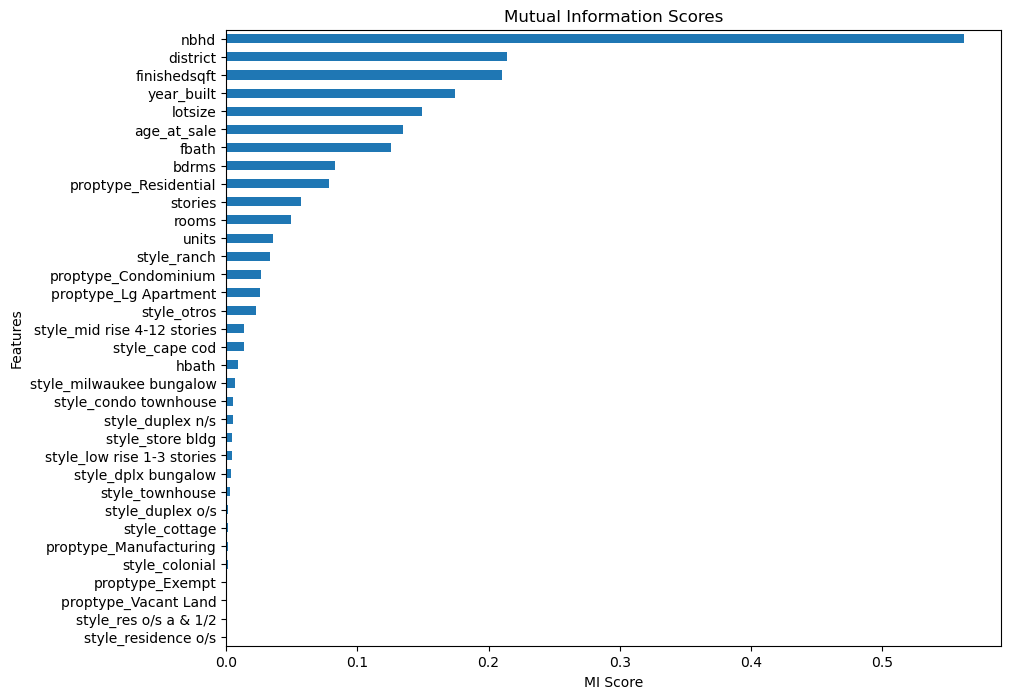

In [20]:

features_to_exclude = ['sale_price']  
X = propiedades.drop(columns=features_to_exclude)
y = propiedades['sale_price'] 

X = pd.get_dummies(X, drop_first=True)

X = X.fillna(0)
y = y.fillna(y.mean())

X = X.apply(pd.to_numeric)
y = pd.to_numeric(y)

mi_scores = mutual_info_regression(X, y)

mi_scores_df = pd.DataFrame(mi_scores, index=X.columns, columns=['MI_Score'])

mi_scores_df = mi_scores_df.sort_values(by='MI_Score', ascending=True)

plt.figure(figsize=(10, 8))
mi_scores_df['MI_Score'].plot(kind='barh')
plt.title('Mutual Information Scores')
plt.xlabel('MI Score')
plt.ylabel('Features')
plt.show()

# Modelización

## Modelo Baseline

In [21]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# He seleccionada las variables más correlacionadas con sale_price y sin alta colinealidad
variables_seleccionadas = [
    'finishedsqft', 'year_built','rooms', 'fbath'
]

X_seleccionado = propiedades[variables_seleccionadas]
y = propiedades['sale_price']

X_train, X_test, y_train, y_test = train_test_split(X_seleccionado, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Resultados del modelo de regresión lineal:\nMAE: {mae}\nRMSE: {rmse}\nMAPE: {mape}")

intercepto = modelo.intercept_
coeficientes = modelo.coef_

print("Coeficientes del modelo:")
for var, coef in zip(variables_seleccionadas, coeficientes):
    print(f"{var}: {coef}")


Resultados del modelo de regresión lineal:
MAE: 64209.03265830249
RMSE: 85583.25076121672
MAPE: 53.0764488675547
Coeficientes del modelo:
finishedsqft: 66.67829468683536
year_built: 879.9860277572504
rooms: 2671.9984200109698
fbath: 6266.5674903816025


C:\Users\ankel\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


## Modelos Boosting

### GradientBoostingRegressor y XGBRegressor

In [22]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


X_boost = propiedades.drop(columns=['sale_price'])
y_boost = propiedades['sale_price']

categorical_features = ['proptype', 'district', 'nbhd', 'style']
numeric_features = ['stories', 'year_built', 'rooms', 'finishedsqft', 'units', 'bdrms', 'fbath', 'hbath',
                    'lotsize', 'age_at_sale']

one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
one_hot_encoder.fit(X_boost[categorical_features])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot_encoder, categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(X_boost, y_boost, test_size=0.2, random_state=42)


pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', GradientBoostingRegressor(random_state=42))])

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', XGBRegressor(random_state=42))])

pipeline_hgbr = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', HistGradientBoostingRegressor(random_state=42))])

pipeline_gb.fit(X_train_boost, y_train_boost)
pipeline_xgb.fit(X_train_boost, y_train_boost)
pipeline_hgbr.fit(X_train_boost, y_train_boost)

y_pred_gb = pipeline_gb.predict(X_test_boost)
y_pred_xgb = pipeline_xgb.predict(X_test_boost)
y_pred_hgbr = pipeline_hgbr.predict(X_test_boost)


mae_gb = mean_absolute_error(y_test_boost, y_pred_gb)
rmse_gb = mean_squared_error(y_test_boost, y_pred_gb, squared=False)  
mape_gb = mean_absolute_percentage_error(y_test_boost, y_pred_gb)

mae_xgb = mean_absolute_error(y_test_boost, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test_boost, y_pred_xgb, squared=False) 
mape_xgb = mean_absolute_percentage_error(y_test_boost, y_pred_xgb)


mae_hgbr = mean_absolute_error(y_test_boost, y_pred_hgbr)
rmse_hgbr = mean_squared_error(y_test_boost, y_pred_hgbr, squared=False)
mape_hgbr = mean_absolute_percentage_error(y_test_boost, y_pred_hgbr)

print(f"\nGradientBoostingRegressor - MAE: {mae_gb}, RMSE: {rmse_gb}, MAPE: {mape_gb}")
print(f"\nXGBRegressor - MAE: {mae_xgb}, RMSE: {rmse_xgb}, MAPE: {mape_xgb}")
print(f"\nHistGradientBoostingRegressor - MAE: {mae_hgbr}, RMSE: {rmse_hgbr}, MAPE: {mape_hgbr}")

joblib.dump(pipeline_gb, 'pipeline_gb_model.pkl')
joblib.dump(pipeline_xgb, 'pipeline_xgb_model.pkl')
joblib.dump(pipeline_hgbr, 'pipeline_hgbr_model.pkl')



C:\Users\ankel\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
C:\Users\ankel\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
C:\Users\ankel\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
C:\Users\ankel\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
C:\Users\ankel\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in vers


GradientBoostingRegressor - MAE: 39903.89748852485, RMSE: 54276.615113168635, MAPE: 32.88580318012921

XGBRegressor - MAE: 29448.27125836262, RMSE: 42654.07416379578, MAPE: 22.007485146731014

HistGradientBoostingRegressor - MAE: 29577.39254757095, RMSE: 42736.83910998602, MAPE: 22.107893861490584


['pipeline_hgbr_model.pkl']

In [23]:
propiedades.columns

Index(['proptype', 'district', 'nbhd', 'style', 'stories', 'year_built',
       'rooms', 'finishedsqft', 'units', 'bdrms', 'fbath', 'hbath', 'lotsize',
       'sale_price', 'age_at_sale'],
      dtype='object')

### HistGradientBoosting con grid de hiperparámetros

C:\Users\ankel\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
C:\Users\ankel\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
C:\Users\ankel\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros


Resultados sobre el conjunto de prueba: MAE: 28965.821007781604, RMSE: 42023.7917652896, MAPE: 21.406881937708246


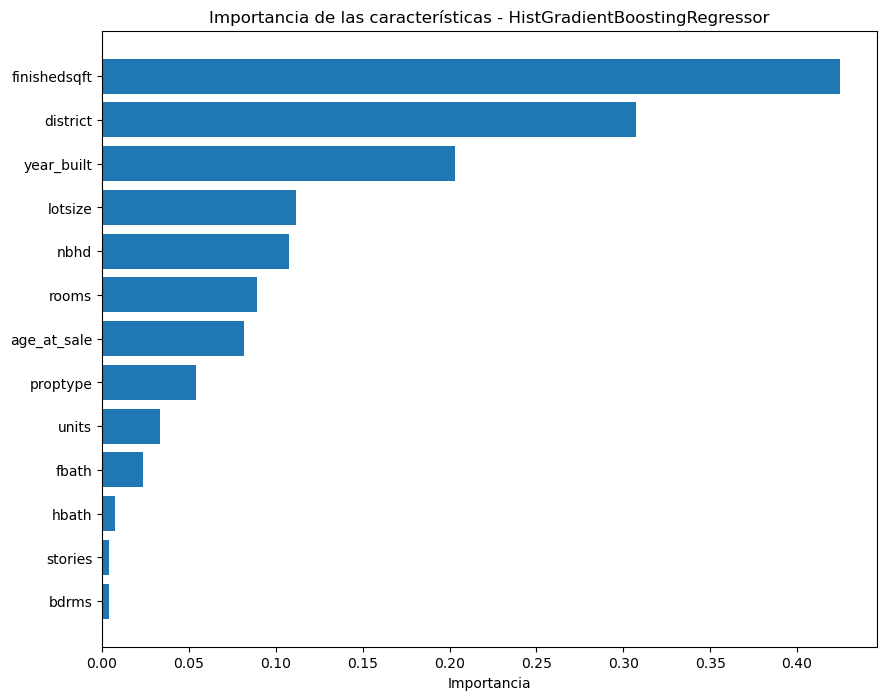

El modelo se ha guardado en 'HistGradientBoosting_GridSearchCV_model.pkl'


In [24]:

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

features_to_exclude = ['sale_price','style'] 
X = propiedades.drop(columns=features_to_exclude)
y = propiedades['sale_price']

categorical_features = ['proptype', 'district', 'nbhd'] 
numeric_features = ['stories', 'year_built', 'rooms', 'finishedsqft', 'units', 'bdrms', 'fbath', 'hbath',
                    'lotsize', 'age_at_sale']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('algoritmo', HistGradientBoostingRegressor())
])

param_grid = {
    'algoritmo__learning_rate': [0.01, 0.05, 0.1],
    'algoritmo__max_iter': [100, 200],
    'algoritmo__max_depth': [5, 10],
    'algoritmo__l2_regularization': [0, 0.5,1],
    'algoritmo__min_samples_leaf': [15,20]
}

scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, scoring=scorers,\
                           refit='MAE', verbose=0, n_jobs=-1, error_score='raise')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

try:
    grid_search.fit(X_train, y_train)
    mejor_modelo = grid_search.best_estimator_
except Exception as e:
    print(f"Error durante el ajuste del modelo: {e}")
    mejor_modelo = None

if mejor_modelo is not None:
    resultados = pd.DataFrame(grid_search.cv_results_)

    columnas_relevantes = [
        'rank_test_MAE', 'mean_test_MAE', 'std_test_MAE',
        'mean_test_RMSE', 'std_test_RMSE',
        'mean_test_MAPE', 'std_test_MAPE',
        'param_algoritmo__learning_rate', 'param_algoritmo__max_iter',
        'param_algoritmo__max_depth', 'param_algoritmo__l2_regularization',
        'param_algoritmo__min_samples_leaf'
    ]

    salida = resultados[columnas_relevantes].sort_values(by='rank_test_MAE').reset_index(drop=True).head(5)

    y_pred = mejor_modelo.predict(X_test)
 
    mae_param_grid = mean_absolute_error(y_test, y_pred)
    rmse_param_grid = mean_squared_error(y_test, y_pred, squared=False)
    mape_param_grid = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Resultados sobre el conjunto de prueba: MAE: {mae_param_grid}, RMSE: {rmse_param_grid}, MAPE: {mape_param_grid}")

    perm_importance = permutation_importance(mejor_modelo, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importancia')
    plt.title('Importancia de las características - HistGradientBoostingRegressor')
    plt.gca().invert_yaxis()
    plt.show()


    joblib.dump(mejor_modelo, 'HistGradientBoosting_GridSearchCV_model.pkl')
    print("El modelo se ha guardado en 'HistGradientBoosting_GridSearchCV_model.pkl'")
else:
    print("No se completo")

In [25]:
importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
6,finishedsqft,0.424746
1,district,0.307093
4,year_built,0.203336
11,lotsize,0.111590
2,nbhd,0.107517
5,rooms,0.089037
12,age_at_sale,0.081935
0,proptype,0.053835
7,units,0.033228
9,fbath,0.023664


         Actual      Predicted
32872  149900.0  113746.146476
273    155000.0  440057.243653
55713  190000.0  247622.018871
34984  139000.0  166460.964044
52976  155000.0  209472.072839


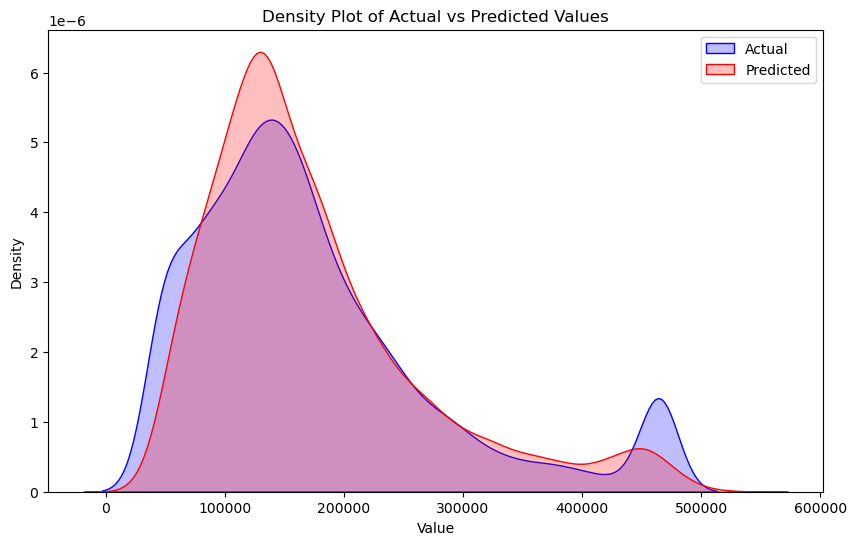

In [26]:

df_predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})


print(df_predictions.head())


plt.figure(figsize=(10, 6))
sns.kdeplot(df_predictions['Actual'], label='Actual', fill=True, color='b')
sns.kdeplot(df_predictions['Predicted'], label='Predicted', fill=True, color='r')
plt.title('Density Plot of Actual vs Predicted Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Resultados y concluisiones

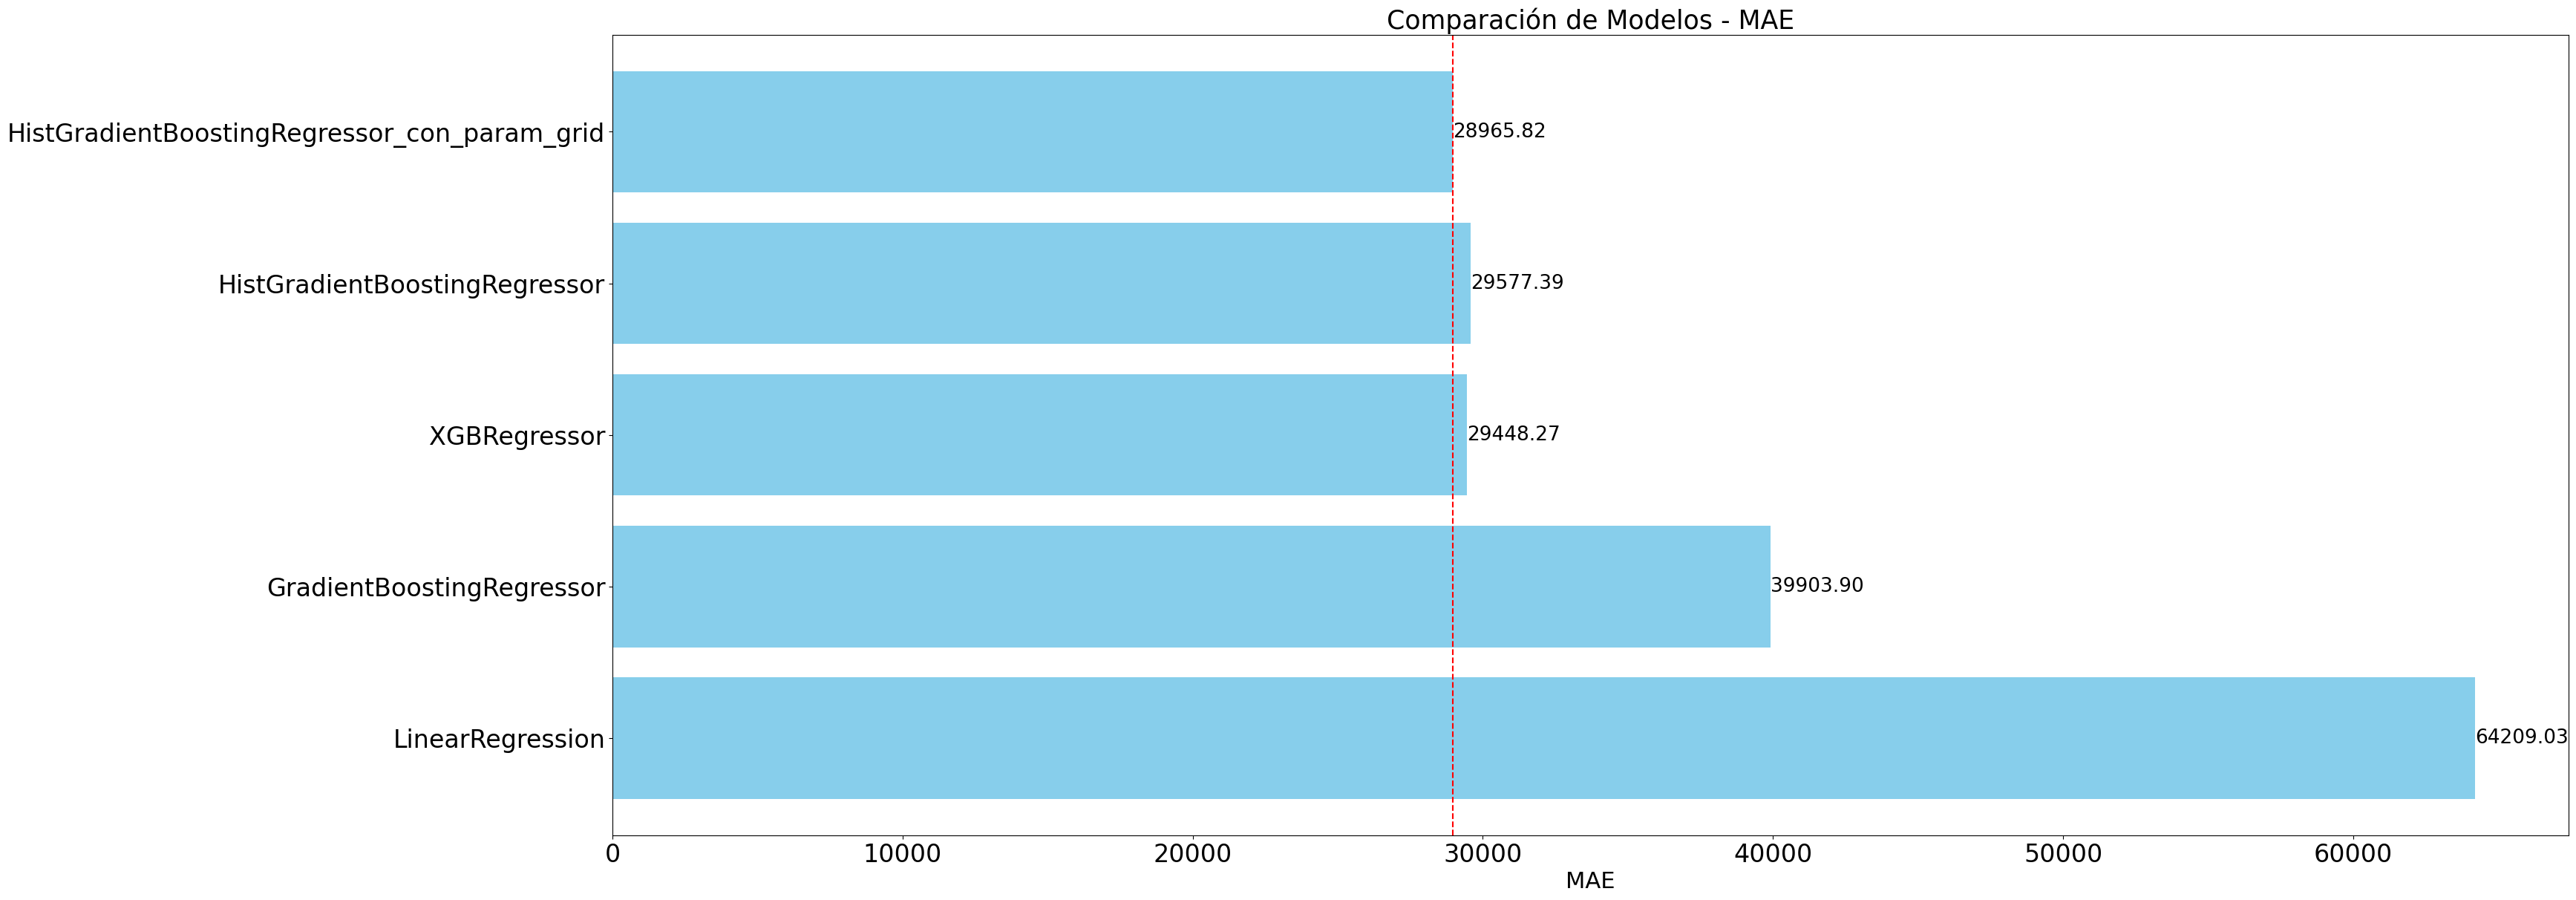

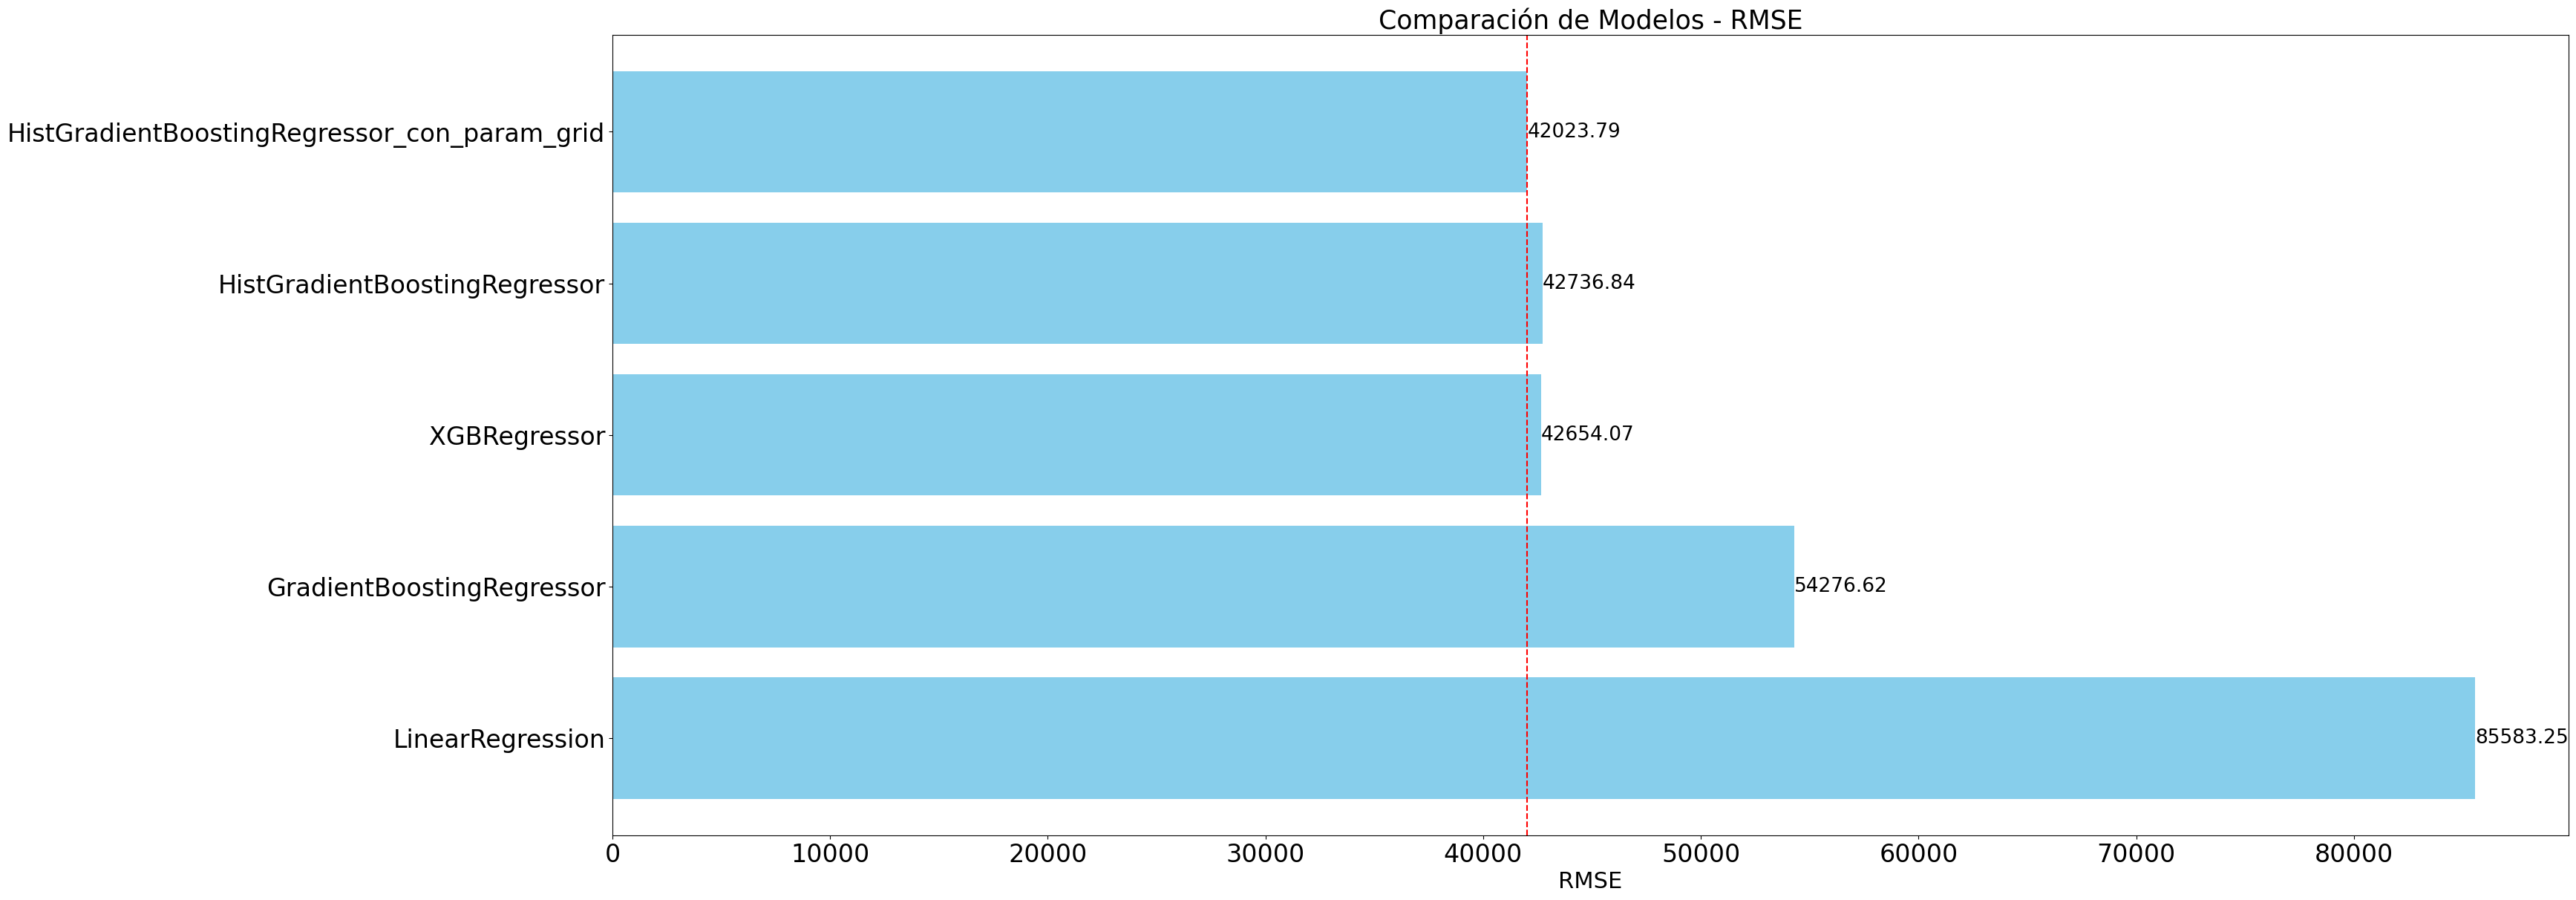

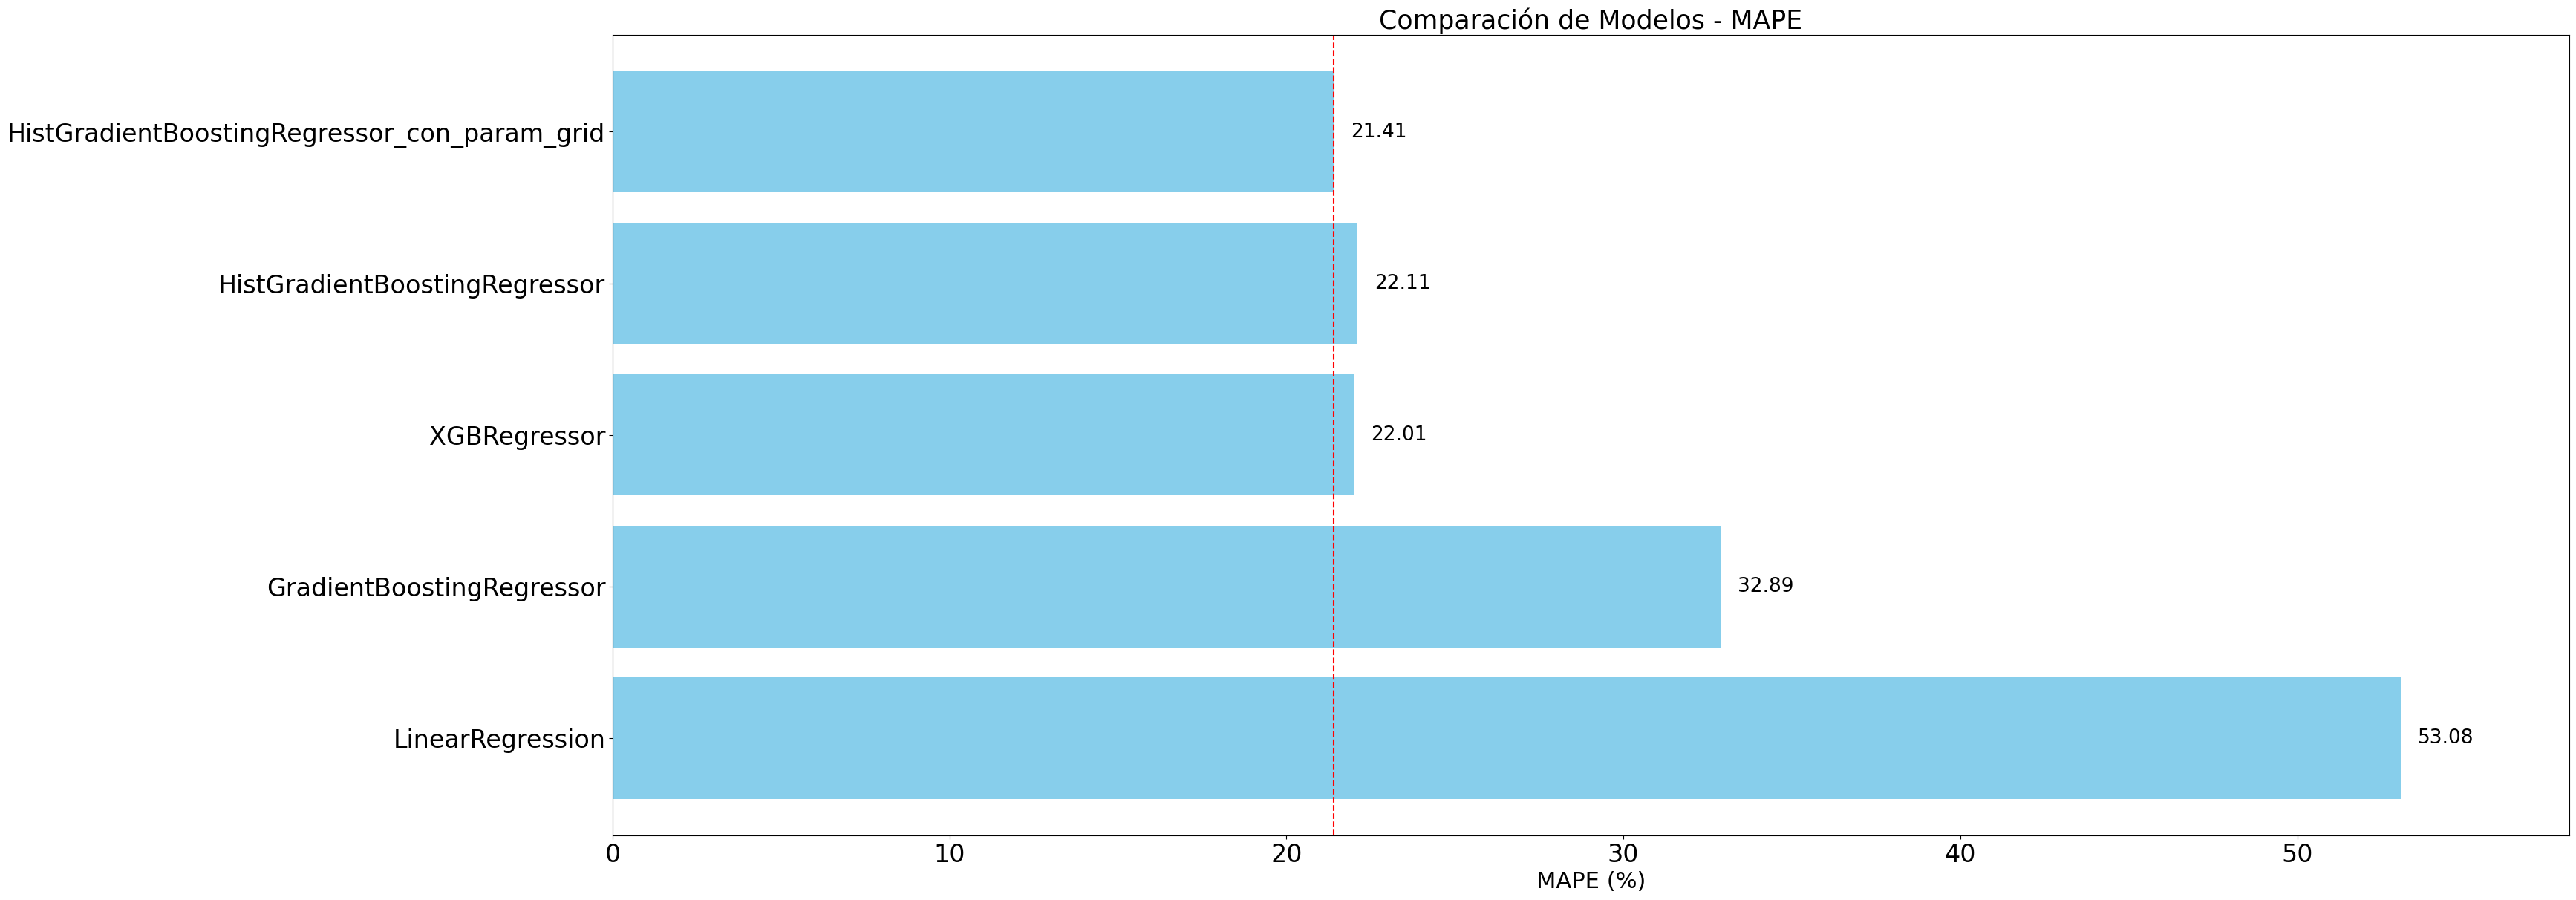

In [27]:


models = [
    "LinearRegression",
    "GradientBoostingRegressor", 
    "XGBRegressor", 
    "HistGradientBoostingRegressor", 
    "HistGradientBoostingRegressor_con_param_grid"
]

mae_values = [mae,mae_gb, mae_xgb, mae_hgbr, mae_param_grid]
rmse_values = [rmse,rmse_gb, rmse_xgb, rmse_hgbr, rmse_param_grid]
mape_values = [mape,mape_gb, mape_xgb, mape_hgbr, mape_param_grid]

plt.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 25,
    'axes.labelsize': 22,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 20,
})

def plot_metric_comparison(metric_values, metric_name, xlabel, xlim=None):
    fig, ax = plt.subplots(figsize=(34,14))
    ax.barh(models, metric_values, color='skyblue')
    ax.set_xlabel(xlabel)
    ax.set_title(f'Comparación de Modelos - {metric_name}')
    
    for i in range(len(models)):
        ax.text(metric_values[i] + 0.5, i, f'{metric_values[i]:.2f}', va='center', fontsize=19)
    
    threshold = min(metric_values)
    ax.axvline(x=threshold, color='red', linestyle='--')

    if xlim:
        ax.set_xlim(xlim)
    
    plt.show()

plot_metric_comparison(mae_values, 'MAE', 'MAE')
plot_metric_comparison(rmse_values, 'RMSE', 'RMSE')
plot_metric_comparison(mape_values, 'MAPE', 'MAPE (%)', xlim=(0, max(mape_values) + 5))
